In [54]:
from bioblend.galaxy import GalaxyInstance
import pandas as pd
from io import StringIO
import os
import requests
import seaborn as sns

# Add galaxy API key
Add `GALAXY_API_KEY` from `https://usegalaxy.eu/user/api_key` via `export GALAXY_API_KEY="<key>"` or `%env  GALAXY_API_KEY=<key>` in jupyter

In [55]:
%env GALAXY_API_KEY=cc8ab6117e2e58a8ca8ac12ce8680ed8

env: GALAXY_API_KEY=cc8ab6117e2e58a8ca8ac12ce8680ed8


# Get collection

In [56]:
history_id = "a90a5dd2a4c17493"
collection_name = "Kraken2 with PlusPF database output report"

gi = GalaxyInstance(url='https://usegalaxy.eu/', key=os.environ['GALAXY_API_KEY'])

datasets = gi.datasets.get_datasets(name = collection_name, history_id = history_id)

#print(datasets)

#fetch collection by name
if len(datasets) > 1:
    print("too many datasets with that name")

for dataset in datasets:
    if dataset['history_content_type']=='dataset_collection': #get only collections
        if dataset['job_state_summary']['all_jobs'] == dataset['job_state_summary']['ok']: #get only collections where all jobs are ok
            dataset_collection_id = dataset["id"]


# get data of the elements in the collection
collection = gi.dataset_collections.show_dataset_collection(dataset_collection_id = dataset_collection_id)




too many datasets with that name


# Download, parse and store elements in collection

In [64]:
dfs = []

for element in collection['elements']:

    element_name = element['element_identifier']

    print(element_name)
    element_id = element['object']['id']
    data = gi.datasets.download_dataset(element_id, maxwait = 3)
    df = pd.read_csv(StringIO(data.decode("utf-8")), sep="\t", header=None)

    # get only species
    df = df.loc[(df.iloc[:,3] == "S1")]

    #set taxa as index without space
    df.index = df.iloc[:,5].str.strip(" ")

    # get only abundance for the sample
    df = df.iloc[:,0]

    df.name = element_name

    dfs.append(df)


Spike1Barcode10
Spike1Barcode11
Spike1Barcode12
Spike1Barcode13
Spike1Barcode14
Spike1Barcode15
 Spike2Barcode10
Spike2Barcode11
Spike2Barcode12
Spike2Barcode13
Spike2Barcode14
Spike2Barcode15
Spike2bBarcode10
Spike2bBarcode11
Spike2bBarcode12
Spike2bBarcode13
Spike2bBarcode14
Spike2bBarcode15
Spike2bUnclassified
Spike3Barcode11
Spike3Barcode13
Spike3Barcode14
Spike3Barcode15
Spike3Unclassified
Spike3bBarcode10
Spike3bBarcode12
Spike3bBarcode11
Spike3bBarcode13
Spike3bBarcode14
Spike3bUnclassified
Spike3bBarcode15
Spike4Barcode01
Spike4Barcode02
Spike4Barcode03
Spike4Barcode04
Spike4Barcode05
Spike4Barcode07
Spike4Barcode08
Spike4Barcode10
Spike4Barcode11
Spike4Barcode12
Spike4Barcode13
Spike4Barcode14
Spike4Barcode15
Spike4Barcode16
Spike4Unclassified


# Merge collection into one file 

In [93]:
#taxa that do not exist in one of the dfs get filled with zero
main_df = pd.concat(dfs, join="outer", axis = 1)
main_df.fillna(0, inplace=True)

main_df.index.name = "Subspecies Relative Abundance [%]"

outpath = "data/output"
os.makedirs(outpath, exist_ok=True)

main_df.to_csv(os.path.join(outpath,"kraken_species_abundance_bio.csv"))

# Adjust data

In [94]:
outpath = "data/output"

#normalize
main_df = pd.read_csv(os.path.join(outpath,"kraken_species_abundance_bio.csv"), index_col=0)

# Normalize between 0 and 1
main_df = main_df.apply(lambda x: x/sum(x),axis = 0)
print(main_df.shape)

# remove species where for no sample more than 0.02 abundance is present
main_df = main_df.loc[(main_df>=0.01).any(axis=1)]

# species on X ?
main_df = main_df.transpose()


(68, 46)


In [95]:
# add metadata
meta_df = pd.read_excel(open('data/Foodborne pathogen detection paper - Data Analysis.xlsx', 'rb'), sheet_name='Biolytix Spiked') 
meta_df.set_index("Galaxy ID", inplace=True)
meta_df.index.name = "Name"

meta_df

# add enrichment table
def set_enrichment_tag(tag):
    if tag == "Yes":
        return("(enriched)")
    if tag == "No":
        return("(not enriched)")
    if tag == "":
        return("(undefined)")

meta_df["Enrichment Tag"] = meta_df["Enrichment"].apply(set_enrichment_tag)

# shorted experted strain
meta_df["Short Strain"] = meta_df["Expected Strain"].str.replace("Salmonella enterica subsp.", "S.")

# add CT to output
def ct_value(ct):
    try:
        return(f"CT: {int(ct)}")
    except:
        return(f"CT: NA")

meta_df["CT tag"] = meta_df["CT Value"].apply(ct_value)
meta_df

# add CFU to output
def cfu_value(cfu):
    try:
        int(cfu)
        number = '{:.1e}'.format(cfu)
        return(f"CFU: {number}")
    except:
        return(f"CFU: NA")

meta_df["CFU tag"] = meta_df["CFU"].apply(cfu_value)

# complete tag
meta_df["Sample Description"] = meta_df["Short Strain"] + " " + meta_df["Enrichment Tag"] + " " + meta_df["CT tag"] + " " + meta_df["CFU tag"]
meta_df

/home/paul/mambaforge/envs/galaxy-api/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


,Sample,Barcode Number,DSM-Number,bx-number,Lot-Number,Data Sequencing Source,Sequencing Date,Information,Expected Strain,Deplition,...,Enrichment,Medium,Galaxy Analysis Date,History Link,Comments,Enrichment Tag,Short Strain,CT tag,CFU tag,Sample Description
Name,,,,,,,,,,,,,,,,,,,,,
Spike1Barcode10,S01,Barcode 10,DSM 554,3042821.0,404.0,Biolytix,19.06.2022,Salmonella enterica subsp. Enterica spike+enri...,Salmonella enterica subsp. Enterica,NaN,...,Yes,Chicken,NaN,NaN,NaN,(enriched),S. Enterica,CT: NA,CFU: NA,S. Enterica (enriched) CT: NA CFU: NA
Spike1Barcode11,S02,Barcode 11,DSM 9221,3042819.0,517.0,Biolytix,19.06.2022,Salmonella enterica subsp. Houtenae spike+enri...,Salmonella enterica subsp. Houtenae,NaN,...,Yes,Chicken,NaN,NaN,NaN,(enriched),S. Houtenae,CT: 24,CFU: 5.8e+07,S. Houtenae (enriched) CT: 24 CFU: 5.8e+07
Spike1Barcode12,S03,Barcode 12,DSM 9220,3042820.0,116.0,Biolytix,19.06.2022,Salmonella enterica subsp. Salamae spike+enric...,Salmonella enterica subsp. Salamae,NaN,...,Yes,Chicken,NaN,NaN,NaN,(enriched),S. Salamae,CT: 19,CFU: 5.8e+08,S. Salamae (enriched) CT: 19 CFU: 5.8e+08
Spike1Barcode13,S04,Barcode 13,DSM 554,3042821.0,404.0,Biolytix,19.06.2022,Salmonella enterica subsp. Enterica spike,Salmonella enterica subsp. Enterica,NaN,...,No,Chicken,NaN,NaN,NaN,(not enriched),S. Enterica,CT: NA,CFU: NA,S. Enterica (not enriched) CT: NA CFU: NA
Spike1Barcode14,S05,Baecode 14,DSM 9221,3042819.0,517.0,Biolytix,19.06.2022,Salmonella enterica subsp. Houtenae spike,Salmonella enterica subsp. Houtenae,NaN,...,No,Chicken,NaN,NaN,NaN,(not enriched),S. Houtenae,CT: 27,CFU: 5.8e+06,S. Houtenae (not enriched) CT: 27 CFU: 5.8e+06
Spike1Barcode15,S06,Barcode 15,DSM 9220,3042820.0,116.0,Biolytix,19.06.2022,Salmonella enterica subsp. Salamae spike,Salmonella enterica subsp. Salamae,NaN,...,No,Chicken,NaN,NaN,NaN,(not enriched),S. Salamae,CT: 29,CFU: 5.8e+05,S. Salamae (not enriched) CT: 29 CFU: 5.8e+05
Spike2Barcode10,S07,Barcode 10,DSM 554,3042821.0,404.0,Biolytix,14.07.2022,Salmonella enterica subsp. Enterica spike+enri...,Salmonella enterica subsp. Enterica,NaN,...,Yes,Chicken,NaN,NaN,NaN,(enriched),S. Enterica,CT: 13,CFU: 1.0e+12,S. Enterica (enriched) CT: 13 CFU: 1.0e+12
Spike2Barcode11,S08,Barcode 11,DSM 9221,3042819.0,517.0,Biolytix,14.07.2022,Salmonella enterica subsp. Houtenae spike+enri...,Salmonella enterica subsp. Houtenae,NaN,...,Yes,Chicken,NaN,NaN,NaN,(enriched),S. Houtenae,CT: 21,CFU: 1.1e+09,S. Houtenae (enriched) CT: 21 CFU: 1.1e+09
Spike2Barcode12,S09,Barcode 12,DSM 9220,3042820.0,116.0,Biolytix,14.07.2022,Salmonella enterica subsp. Salamae spike+enric...,Salmonella enterica subsp. Salamae,NaN,...,Yes,Chicken,NaN,NaN,NaN,(enriched),S. Salamae,CT: 18,CFU: 9.0e+07,S. Salamae (enriched) CT: 18 CFU: 9.0e+07


# Merge meta and taxonomy data 

In [97]:

main_df_columns = main_df.columns

frames = [main_df, meta_df]
result = pd.concat(frames, axis = 1)

result.set_index("Sample Description", inplace = True)

result = result.loc[:,main_df_columns]
result = result[result.index.notnull()]

print(result.shape)

result = result.dropna(axis = 0)

print(result.shape)
result

(46, 11)
(34, 11)


Subspecies Relative Abundance [%],Salmonella enterica subsp. enterica,Salmonella enterica subsp. salamae,Bacillus cereus F,Saccharomyces cerevisiae S288C,Salmonella enterica subsp. houtenae,Bacillus cereus NC7401,Bacillus cereus FRI-35,Serratia liquefaciens ATCC 27592,Streptococcus cristatus ATCC 51100,Carnobacterium maltaromaticum LMA28,Pseudomonas syringae UMAF0158
Sample Description,,,,,,,,,,,
S. Enterica (enriched) CT: NA CFU: NA,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
S. Houtenae (enriched) CT: 24 CFU: 5.8e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
S. Salamae (enriched) CT: 19 CFU: 5.8e+08,0.053571,0.482143,0.285714,0.000000,0.000000,0.142857,0.035714,0.000000,0.000000,0.000000,0.0
S. Salamae (not enriched) CT: 29 CFU: 5.8e+05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
S. Enterica (enriched) CT: 13 CFU: 1.0e+12,0.315789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.631579,0.052632,0.000000,0.0
S. Houtenae (enriched) CT: 21 CFU: 1.1e+09,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5
S. Salamae (enriched) CT: 18 CFU: 9.0e+07,0.500000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.0
S. Houtenae (not enriched) CT: 28 CFU: 6.8e+04,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
S. Enterica (enriched) CT: 13 CFU: 1.0e+12,0.315789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.631579,0.052632,0.000000,0.0


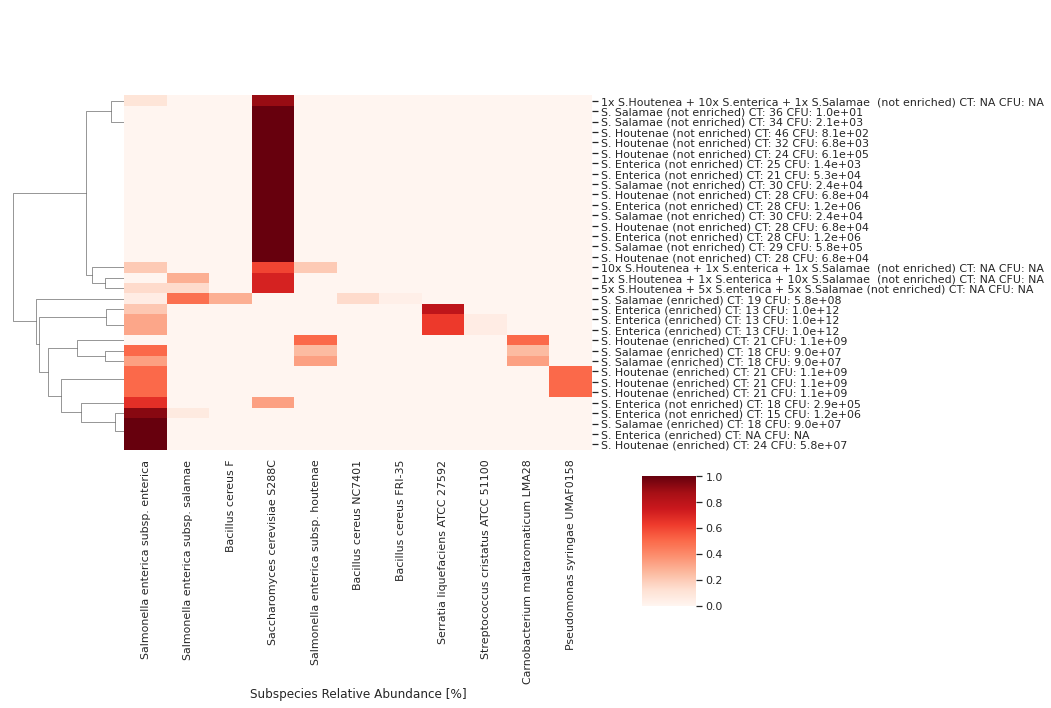

In [116]:
# plot
#from matplotlib import rcParams

# figure size in inches
#rcParams['figure.figsize'] = 20,20

#result = result.transpose()
# sns.heatmap(main_df, cmap = )
g = sns.clustermap(result, cmap="Reds", xticklabels=True, col_cluster=False, figsize=(15,10), cbar_pos=(0.6, 0.15, 0.05, 0.18))
ax = g.ax_heatmap
ax.set_ylabel("")

# fig = g.get_figure()
plt.savefig(os.path.join(outpath, "clustermap_subspecies_relative_abundance_biolytix.svg"))

#setting the scale
# cbnorm = Normalize(vmin=0-0.5,vmax=5+0.5,clip=False) #setting the scale
# cb = plt.colorbar(cm.ScalarMappable(norm=cbnorm, cmap=newcmp),fraction=1,ax=ax_color,ticks=np.arange(6))